In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrices_for_column_pairs(df, gt_col,vis_columns):

    n_pairs = len(vis_columns)

    # Determine layout: square-ish grid
    n_cols = int(np.ceil(np.sqrt(n_pairs)))
    n_rows = int(np.ceil(n_pairs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    col1 = gt_col
    for idx, col2 in enumerate(vis_columns):
        ax = axes[idx]
        
        # Drop rows with missing values in either column
        sub_df = df[[col1, col2]].dropna().copy()
        start_length = len(sub_df)
        # sub_df = sub_df[sub_df.apply(lambda x: True if ("_" not in x[col1] and '_' not in x[col2]) else False, axis=1)]
        filter_length = len(sub_df)
        # Get confusion matrix
        labels = sorted(set(sub_df[col1]) | set(sub_df[col2]))
        cm = confusion_matrix(sub_df[col1], sub_df[col2], labels=labels)

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(f"{col1} vs \n{col2}\n strt: {start_length}\nelim.:{filter_length-start_length}", fontsize=10)
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)

    # Hide any extra axes
    for j in range(len(vis_columns), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    return fig


********************Sleep************************
Sleep_132_222_att_False
 False Sleep_132_222_att_False


is_keyword_present
False    221
True     131
Name: count, dtype: int64

GT_Sleep  is_keyword_present
0         False                 219
1         True                  110
0         True                   21
1         False                   2
Name: count, dtype: int64
file written to ../exports/disagreements/Sleep/all_all_Sleep_132_222_att_False.xlsx


,technique,pos_sup,neg_sup,f1_score,precision,recall,time
0,dictionary,112,240,0.905350,0.839695,0.982143,0.002270
1,LLM_KiSi,112,240,0.903226,0.823529,1.000000,14.834405
2,LLM__keyword_evidence,112,240,0.903226,0.823529,1.000000,14.921283
3,LLM__example_evidence,112,240,0.881890,0.788732,1.000000,14.806389
4,LLM_,112,240,0.881890,0.788732,1.000000,14.924491


********************Excretion************************


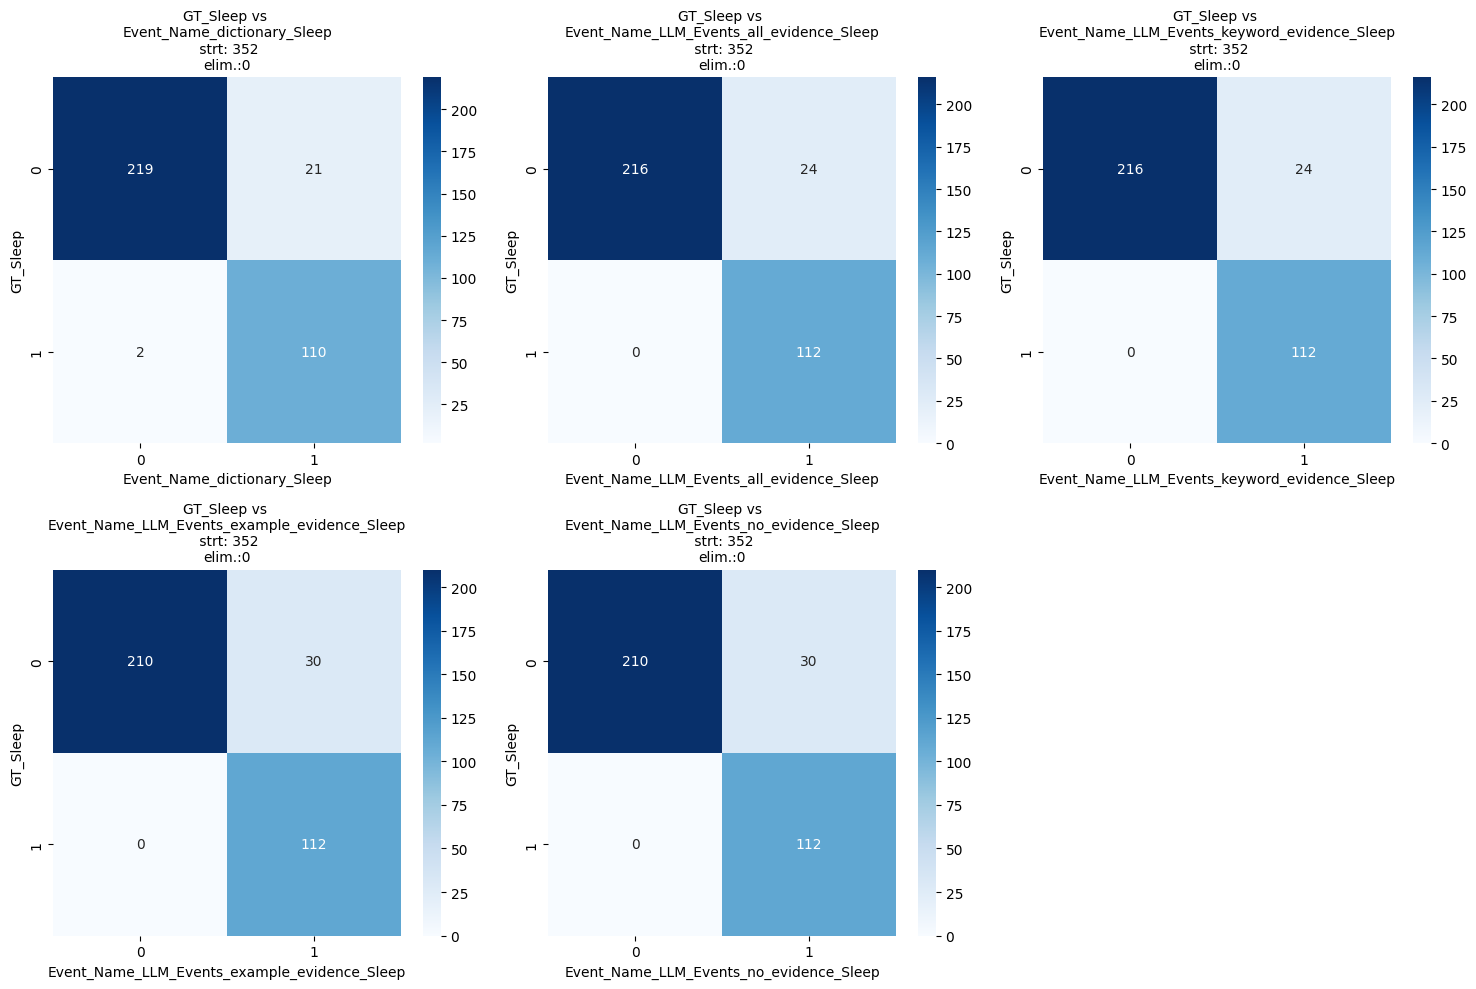

In [ ]:
from glob import glob
import os
import pandas as pd
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from itertools import product
disagreement_type = "correct"
def get_time(x):
    x = np.array(x)
    # Remove NaNs
    x = x[~np.isnan(x)]
    # If less than 3 values, just return mean
    if len(x) < 3:
        return np.mean(x)
    # Remove outliers using IQR
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    mask = (x >= q1 - 1.5 * iqr) & (x <= q3 + 1.5 * iqr)
    return np.mean(x[mask])

def get_event(x):
    global event_types
    if x["event"] != "Unknown":
        return x["event"]
    x = x.copy()  
    try:
        raw = x.get("raw_output", "")
        if isinstance(raw, str):
            parsed = json.loads(raw)
            fields = parsed.keys()
            common_to_labels = set(fields).intersection(set(event_types+["Unknown"])) 
            if "event_type" in fields:
                x["event"] = parsed.get("event_type")
            elif "event type" in fields:
                x["event"] = parsed.get("event type")
            elif len(common_to_labels) > 0:
                x["event"] = list(common_to_labels)
            else:
                x["event"] = "Unknown"
        else:
            x["event"] = "Unknown"
    except (json.JSONDecodeError, TypeError):
        x["event"] = "Unknown"
    return x["event"]

def fixnames(ls,suffix,remove):
    LS=[]
    for s in ls:
        s = s.replace("_dict_evidence","_Ki").replace("_embedder_evidence","_Si").replace("_no_evidence","").replace("_all_evidence","KiSi").replace("Event_Name_",'').replace("_Events",'_').replace('_'+remove,"")
        LS.append(s+suffix)
    return LS

def get_col_suffix(keyword_input, example_input):
    col_suffix = "no"
    if keyword_input and example_input:
        col_suffix = "all"
    elif keyword_input and not example_input:
        col_suffix = "keyword"
    elif not keyword_input and example_input:
        col_suffix = "example"
    return col_suffix

def get_keyword(x, event_type):
    x = x.copy()  # avoid modifying original
    try:
        raw = x.get("raw_output", "")
        if isinstance(raw, str):
            parsed = json.loads(raw)
            fields = parsed.keys()
            common_to_labels = set(fields).intersection(set(["Unknown", "Eating", "Sleep", "Excretion", "Family", "Pain"])) 
            if "keyword" in fields:
                x["keyword"] = parsed.get("keyword")
                if type(x["keyword"]) == dict:
                    if event_type in x["keyword"]:
                        x["keyword"] = x["keyword"][event_type]
                    else:
                        x["keyword"] = "Unknown"
            elif "keywords" in fields:
                x["keyword"] = parsed.get("keywords")
                if type(x["keyword"]) == dict:
                    if event_type in x["keyword"]:
                        x["keyword"] = x["keyword"][event_type]
                    else:
                        x["keyword"] = "Unknown"
            elif event_type in fields:
                x["keyword"] = parsed.get(event_type)
            else:
                x["keyword"] = "Unknown"
        else:
            x["keyword"] = "Unknown"
    except (json.JSONDecodeError, TypeError):
        x["keyword"] = "Unknown"
    return x["keyword"]

LLM_dict = {}
llm_models = []
for keyword_input, example_input in [i for i in product([True,False],[True,False])]: 
    col_suffix = get_col_suffix(keyword_input, example_input)
    llm_models.append(f"LLM_Events_{col_suffix}_evidence")
df_both = pd.read_pickle("../exports/dictionary_biolord_features.pkl")
for analysis_type in ["all"]: #(M-SET, A-SET, D-SET, F-SET)
    for ET in ["Sleep","Excretion"]:
        print(f"********************{ET}************************")
        llm_files = glob(f"../exports/llm/{ET}/*.pkl")
        gt_file = glob(f"../exports/groundtruth/F-SET/Annotated/{ET}*.xlsx")[0]
        gt_df = pd.read_excel(gt_file)
        gt_df = gt_df.dropna(subset=f"gt_{ET}")
        
            
        gt_df = gt_df.groupby("UID")[[f"{ET}_similarity", f"gt_{ET}", "is_keyword_present", "Sentence_dictionary","Lemma","HADM_ID"]].agg(lambda x: max(x) if len(set(x))>1 else set(x).pop()).reset_index()
        uid_to_gt = {row['UID']:row[f"gt_{ET}"] for _,row in gt_df.iterrows()}
        uid_to_key_present = {row['UID']:row[f"is_keyword_present"] for _,row in gt_df.iterrows()}
        uid_to_lemma = {row['UID']:row[f"Lemma"] for _,row in gt_df.iterrows()}
        uid_to_hadmid = {row['UID']:row[f"HADM_ID"] for _,row in gt_df.iterrows()}
        uid_to_dict_time = {row['UID']:row[f"Time_dictionary"] for _,row in df_both.iterrows()}
        output_folder = f"../exports/disagreements/{ET}"
        os.makedirs(output_folder,exist_ok=True)
        for file in llm_files:
            filename = os.path.basename(file).rstrip('.pkl')
            print(filename)
            _,attribute_requested = filename.split("_")[-2:]
            attribute_requested = eval(attribute_requested)
            
            suffix = "Ao" if attribute_requested else "" 
            
            
            print(suffix,attribute_requested,filename)
            
            df = pd.read_pickle(file)
            df[f'dictionary_{ET}_time'] = df["UID"].apply(lambda x:uid_to_dict_time.get(x))
            df[f"{ET}_similarity"] = df['Similarity'].apply(lambda x: x[ET])
            df["Keyword_dictionary"] = df["Keyword"]
            df["focus_event"] = ET
            df[f"GT_{ET}"] = df["UID"].apply(lambda x:uid_to_gt.get(x))
            df[f"is_keyword_present"] = df["UID"].apply(lambda x:uid_to_key_present.get(x))
            display(df.is_keyword_present.value_counts())
            
            print(df[[f"GT_{ET}","is_keyword_present"]].value_counts())
                        
            df[f"dict_Lemma"] = df["UID"].apply(lambda x:uid_to_lemma.get(x))
            df[f"HADM_ID"] = df["UID"].apply(lambda x:uid_to_lemma.get(x))
            df.dropna(subset=f"GT_{ET}",inplace=True)
            for col in llm_models:
                df[f"{col}_{ET}_time"] = df[col].apply(lambda x:x['event_detection_time'])
            if len(df) > 1:
                first_row = df.iloc[0]
                splittable_columns = ["Event_Name_dictionary"]+[f"Event_Name_{model}" for model in llm_models]
                disagreement_dfs = []
                generated_columns = []

                for col in splittable_columns:
                    generated_column = f"{col}_{ET}"
                    df[generated_column] = df[col].apply(lambda x: 1 if ET in x else 0)
                    
                    generated_columns.append(generated_column)
                
                f1s, accs, precs, recs, psup, nsup, times = [],[],[],[],[],[],[]
                y_gt = df[f"GT_{ET}"]
                LLM_dict[(attribute_requested,f"gt_{ET}")] = y_gt
                for col in generated_columns:
                    preds = df[col]
                    LLM_dict[(attribute_requested,col)] = preds
                    f1s.append(f1_score(y_gt, preds))
                    accs.append(accuracy_score(y_gt, preds))
                    precs.append(precision_score(y_gt, preds, zero_division=0))
                    recs.append(recall_score(y_gt, preds))   
                    psup.append(sum(y_gt))
                    nsup.append(sum(y_gt==0))
                    times.append(get_time(df[f"{col.lstrip('Event_Name_')}_time"]))
                
            
                results_df = {"technique":fixnames(generated_columns,suffix,ET), "pos_sup": psup, "neg_sup": nsup, "f1_score":f1s, "precision":precs, "recall":recs, "time":times} 
                results = pd.DataFrame(results_df)   
                plot_confusion_matrices_for_column_pairs(df, f"GT_{ET}",vis_columns=generated_columns)
                op_path = f"{output_folder}/{analysis_type}_{disagreement_type}_{filename}.xlsx"


                df.to_excel(op_path,index=False)
                print(f"file written to {op_path}")
                display(results)
        

